In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from random import sample
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

Zdefiniowanie funkcji losującej punkty.

In [34]:
def draw_data_gauss(S1, S2, m1, m2, n1, n2):
    X1 = np.random.multivariate_normal(m1, S1, n1) #losowanie obserwacji w klasach na podstawie wcześniejszych parametrów
    X2 = np.random.multivariate_normal(m2, S2, n2)
    
    X1_data = pd.DataFrame(X1, columns = ["x", "y"])
    X1_data["class"] = [1] * len(X1)
    X2_data = pd.DataFrame(X2, columns = ["x", "y"])
    X2_data["class"] = [2] * len(X2)
    XX = X1_data.append(X2_data, ignore_index = True,  sort = False)
    return XX

Utworzenie zestawu danych.

In [35]:
d1 = {'x':[4,2],'y':[2,4]}
d2 = {'x':[4,2],'y':[2,2]}
S1 = pd.DataFrame(d1)    #macierz kowariancji
S2 = pd.DataFrame(d2)    
m1 = np.array([-1,-1]) #średnie klas
m2 = np.array([2,2])
n1 = 30                #liczebność klas
n2 = 20
n = n1+n2
X = draw_data_gauss(S1, S2, m1, m2, n1, n2)

Rozpięcie siatki

In [36]:
x = np.arange(-5, 5, 0.1)
y = np.arange(-5, 5, 0.1)
xx = np.array(np.meshgrid(x, y)).reshape(2, len(x)*len(y)).T
df = pd.DataFrame(xx, columns = ["x","y"])

Deklaracja tablic

In [37]:
C = np.array(range(2, 12, 2))/10
svm_score = np.zeros(len(C))
b = np.zeros(len(C))
w = np.zeros((len(C),2))

Wyznaczenie parametrów dopasowania LDA i SVM dla różnych C, wizualizacja podziału, narysowanie zależności skuteczności klasyfikatora od parametru C. Skuteczność uzyskana na podstawie średniej z 10-krotnej kroswalidacji.

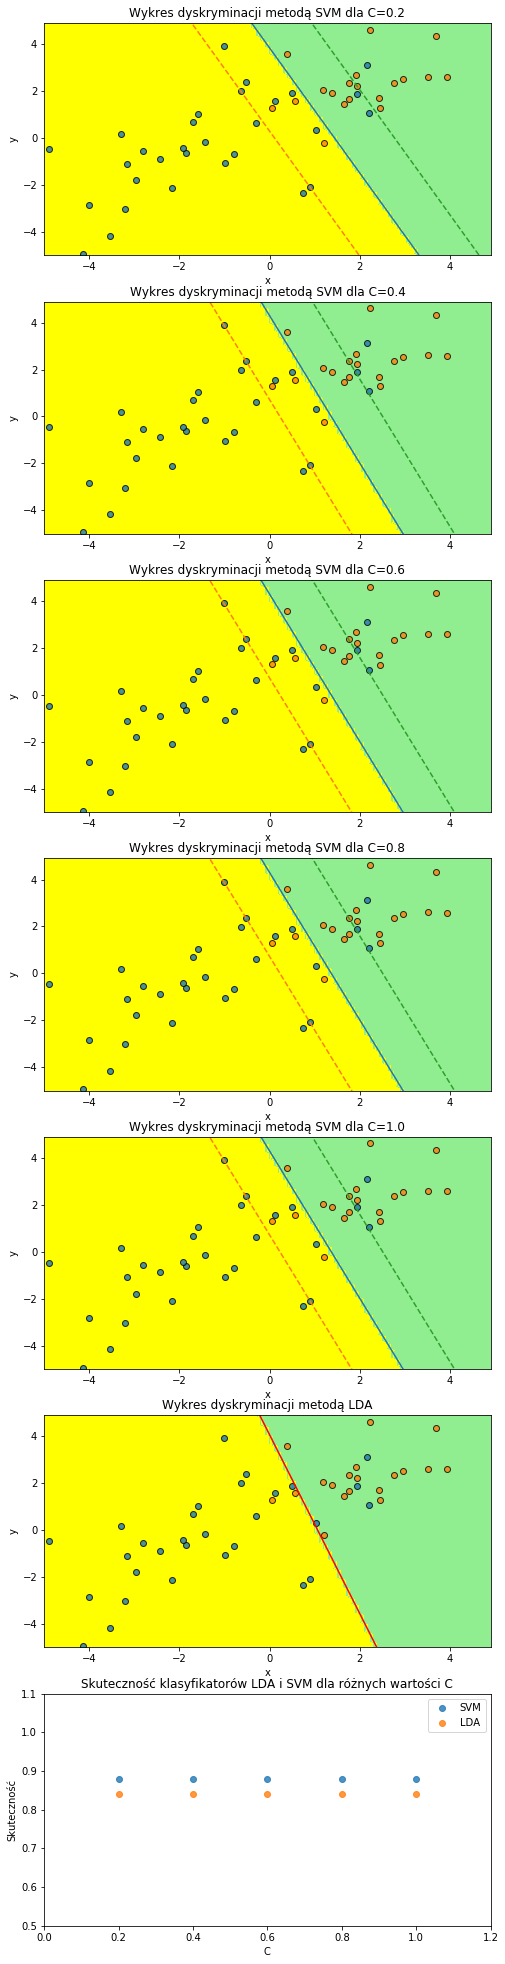

In [38]:
fig, ax = plt.subplots(len(C)+2,1, figsize=(8,35))

for i in range(len(C)):
    svm = SVC(C=C[i], kernel = "linear")
    svm_score[i] = cross_val_score(svm, X[X.columns[:2]], X["class"], cv = 10).mean()
    svm_fit = svm.fit(X[X.columns[:2]], X["class"])
    #zapisanie wektorów podpierających oraz odpowiadających im wartości alfa
    SV = pd.DataFrame(svm_fit.support_vectors_, columns = ["x", "y"])
    SVcoef = pd.DataFrame(svm_fit.dual_coef_.reshape(sum(svm_fit.n_support_),1), columns = ["coef"])
    SV = SV.join(SVcoef)
    predictions = svm.fit(X[["x","y"]], X["class"]).predict(df).reshape(len(x),len(y))
    b[i] = svm_fit.intercept_
    w[i,:] = np.dot(np.transpose(SV[["x", "y"]]), SV["coef"])
    #rysowanie wykresów klasyfikacji metodą SVM
    ax[i].contourf(x,y, predictions, colors = ["yellow", "lightgreen"])
    ax[i].scatter(X.loc[X["class"]==1,["x"]], X.loc[X["class"]==1,["y"]], label = "Class 1", alpha = 0.8, edgecolors='k')
    ax[i].scatter(X.loc[X["class"]==2,["x"]], X.loc[X["class"]==2,["y"]], label = "Class 2", alpha = 0.8, edgecolors='k')
    ax[i].plot(x,-w[i,0]/w[i,1]*x-b[i]/w[i,1])
    ax[i].plot(x,-w[i,0]/w[i,1]*x-(b[i]+1)/w[i,1], ls = '--')
    ax[i].plot(x,-w[i,0]/w[i,1]*x-(b[i]-1)/w[i,1], ls = '--')
    ax[i].set_xlim(df["x"].min(), df["x"].max())
    ax[i].set_ylim(df["y"].min(), df["y"].max())
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].set_title("Wykres dyskryminacji metodą SVM dla C=" +str(C[i]))
#klasyfikator LDA
lda = LDA()
LDA_score = cross_val_score(lda, X[X.columns[:2]], X["class"], cv = 10).mean()
LDA_fit = lda.fit(X[X.columns[:2]], X["class"])
predictions = LDA_fit.predict(df).reshape(len(x),len(y))
b_LDA = LDA_fit.intercept_
y_LDA = -1*(b_LDA[0]+x*LDA_fit.coef_[0][0])/LDA_fit.coef_[0][1]
#rysowanie wykresu klasyfikacji metodą LDA
ax[len(C)].contourf(x,y, predictions, colors = ["yellow", "lightgreen"])
ax[len(C)].plot(x,y_LDA, '-r')
ax[len(C)].scatter(X.loc[X["class"]==1,["x"]], X.loc[X["class"]==1,["y"]], label = "Class 1", alpha = 0.8, edgecolors='k')
ax[len(C)].scatter(X.loc[X["class"]==2,["x"]], X.loc[X["class"]==2,["y"]], label = "Class 2", alpha = 0.8, edgecolors='k')
ax[len(C)].set_xlim(df["x"].min(), df["x"].max())
ax[len(C)].set_ylim(df["y"].min(), df["y"].max())
ax[len(C)].set_xlabel('x')
ax[len(C)].set_ylabel('y')
ax[len(C)].set_title("Wykres dyskryminacji metodą LDA")
#rysowanie wykresu skuteczności zależnej od C
LDA_score_array = np.full(len(C),LDA_score)
ax[len(C)+1].scatter(C,svm_score, alpha = 0.8, label = 'SVM')
ax[len(C)+1].scatter(C,LDA_score_array, alpha = 0.8, label = 'LDA')
ax[len(C)+1].set_xlim(0, 1.2)
ax[len(C)+1].set_ylim(0.5, 1.1)
ax[len(C)+1].set_xlabel('C')
ax[len(C)+1].set_ylabel('Skuteczność')
ax[len(C)+1].set_title("Skuteczność klasyfikatorów LDA i SVM dla różnych wartości C")
ax[len(C)+1].legend()

In [40]:
print(svm_score)
print(LDA_score_array)
print(b)

[0.88 0.88 0.88 0.88 0.88]
[0.84 0.84 0.84 0.84 0.84]
[-1.08190088 -1.19944318 -1.19954414 -1.19917707 -1.19915055]


Na podstawie oceny klasyfikatorów metodą kroswalidacji, widać, że klasyfikator SVM wypada odrobinę lepiej od LDA, jednak generalnie ich wyniki są do siebie zbliżone. 